In [1]:
import torch
import torchvision
from variational_autoencoder_FireEvac import VariationalAutoencoder
from typing import Tuple
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0) # ensures reproducibility

plt.rcParams['figure.dpi'] = 200
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

FIGURE_PATH = "figures/T4_"
INPUT_DIMENSION = 2
LATENT_DIMS = 2

%load_ext autoreload
%autoreload 2

In [24]:
train_data = np.load("FireEvac_train_set.npy")
test_data = np.load("FireEvac_test_set.npy")

def normalise(data: np.ndarray) -> np.ndarray:
    data[:,0] = data[:,0] / data[:,0].max()
    data[:,1] = data[:,1] / data[:,1].max()
    return data

def create_data_loader(data: np.ndarray) -> torch.utils.data.DataLoader:
    data = normalise(data)

    data = Tensor(data)
    data = torch.utils.data.TensorDataset(data)
    dataloader = torch.utils.data.DataLoader(data,
                                            batch_size=128,
                                            shuffle=True)
    return dataloader

train_data_loader = create_data_loader(train_data)
test_data_loader = create_data_loader(test_data)

In [25]:
train_data_loader.dataset[:][0].numpy()

array([[0.45992416, 0.5772299 ],
       [0.40078706, 0.72252935],
       [0.65492785, 0.78980356],
       ...,
       [0.28028473, 0.4398623 ],
       [0.03567113, 0.45813817],
       [0.18097514, 0.40385687]], dtype=float32)

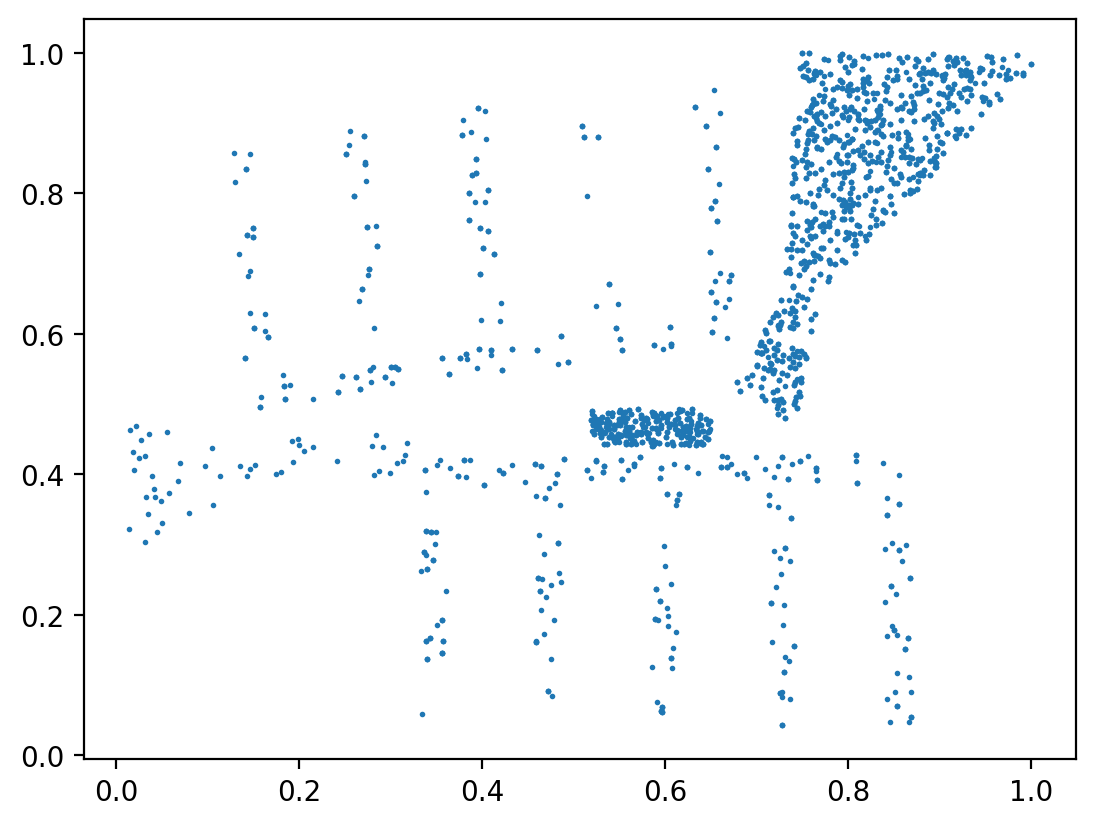

In [20]:
x = train_data_loader.dataset[:][0].numpy()[:,0]
y = train_data_loader.dataset[:][0].numpy()[:,1]
plt.scatter(x, y, s=1)
plt.show()

In [5]:
autoencoder = VariationalAutoencoder(LATENT_DIMS).to(DEVICE)

loss_history = []

In [6]:
def loss_per_batch(autoencoder: VariationalAutoencoder, x: Tensor) -> Tensor:
    mu_decoder = autoencoder(x)
    reconstruction_loss = ((x - mu_decoder)**2).sum()
    sigma_decoder = torch.exp(autoencoder.decoder.log_sigma)
    batch_size = x.shape[0]
    loss = reconstruction_loss / (2 * sigma_decoder**2) \
            + autoencoder.encoder.kl \
            + batch_size * INPUT_DIMENSION * torch.log(sigma_decoder)
    return loss

def train(autoencoder: VariationalAutoencoder,
          training_data,
          test_data,
          epochs: int,
          loss_history: list) -> Tuple[VariationalAutoencoder, list]:
    opt = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    for _ in range(epochs):
        for x, in training_data:
            x = x.to(DEVICE) # send to GPU
            opt.zero_grad()
            loss = loss_per_batch(autoencoder, x)
            loss.backward()
            opt.step()

        test_loss = 0  # aggregate loss over all batches in this variable
        for x, in test_data:
            x = x.to(DEVICE)
            test_loss += loss_per_batch(autoencoder, x) / len(training_data)

        loss_history.append(test_loss.to("cpu").item())

    return autoencoder, loss_history

In [11]:
autoencoder, loss_history = train(autoencoder, train_data_loader, test_data_loader, epochs=3000, loss_history=loss_history)

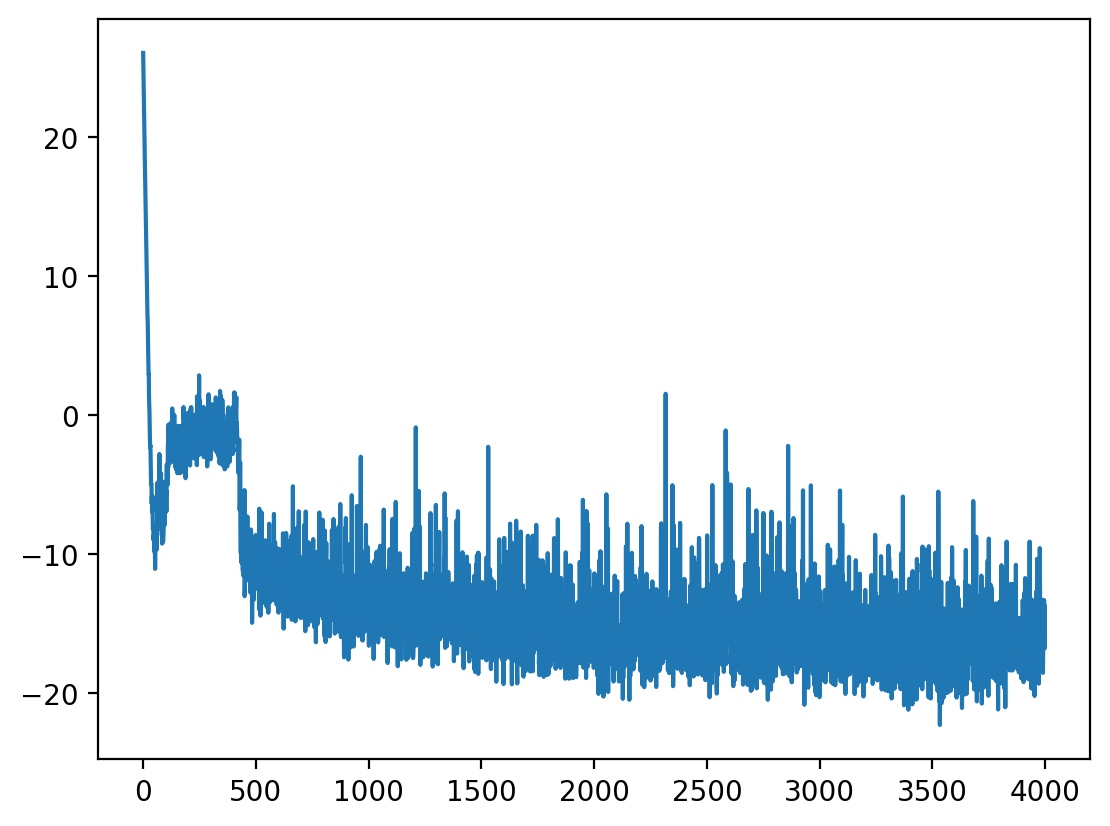

In [12]:
plt.plot(loss_history)

In [13]:
reconstructed_train = autoencoder(Tensor(normalise(train_data)).to(DEVICE))
reconstructed_train = reconstructed_train.to("cpu").detach().numpy()
reconstructed_test = autoencoder(Tensor(normalise(test_data)).to(DEVICE))
reconstructed_test = reconstructed_test.to("cpu").detach().numpy()

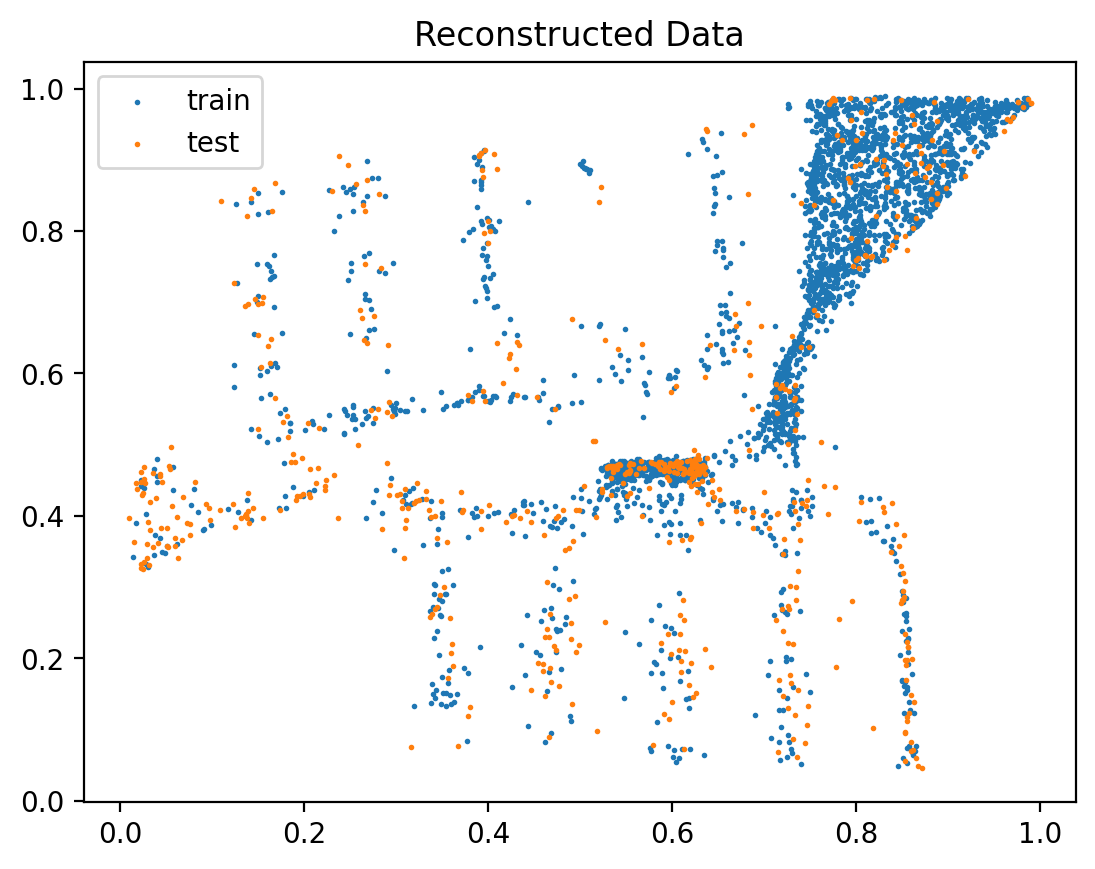

In [21]:
plt.scatter(reconstructed_train[:,0], reconstructed_train[:,1], label="train", s=1)
plt.scatter(reconstructed_test[:,0], reconstructed_test[:,1], label="test", s=1)
plt.legend()
plt.title("Reconstructed Data")
plt.savefig(FIGURE_PATH + "reconstructed.png", bbox_inches='tight')
plt.show()

In [15]:
latent_random_samples = torch.randn((3000, 2))
generated = autoencoder.decoder(latent_random_samples.to(DEVICE))
generated = generated.to("cpu").detach().numpy()

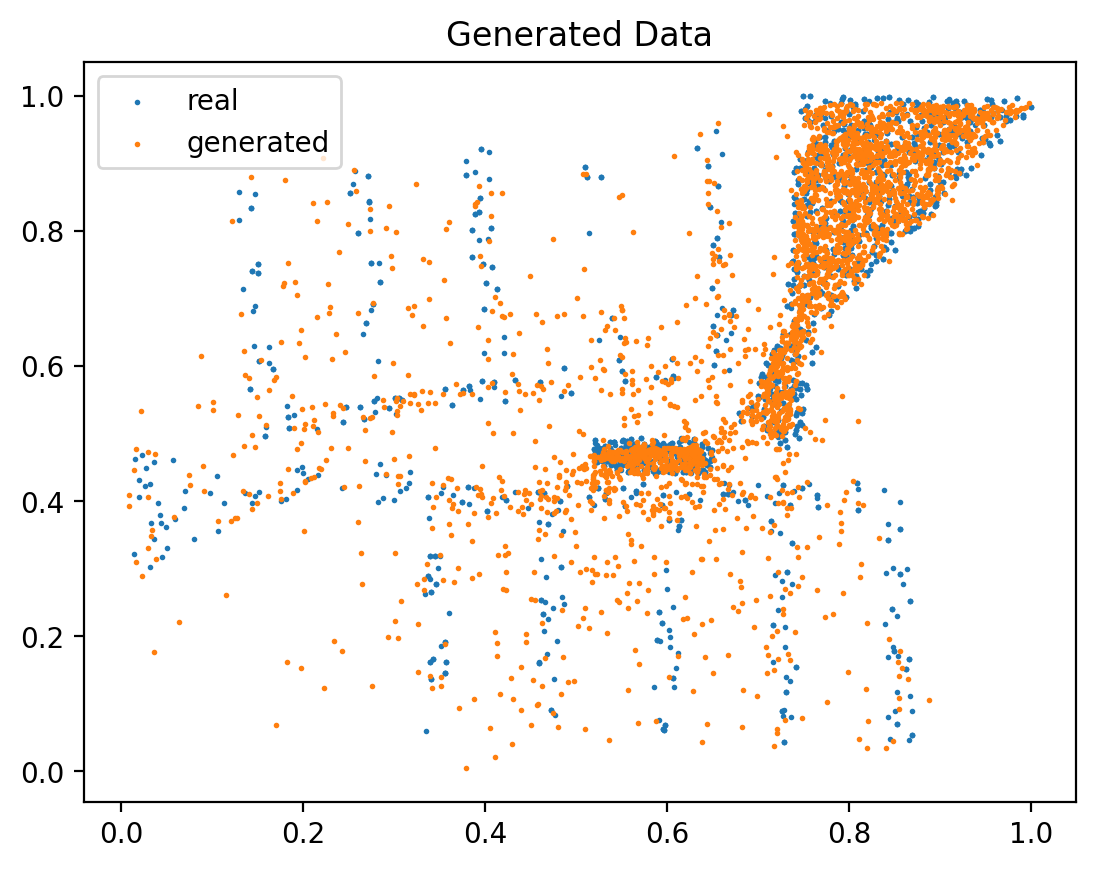

In [23]:
plt.scatter(x, y, label="real", s=1)
plt.scatter(generated[:,0], generated[:,1], label="generated", s=1)
plt.title("Generated Data")
plt.legend()
plt.savefig(FIGURE_PATH + "generated.png", bbox_inches='tight')
plt.show()

In [29]:
def count_in_rectangle(pedestrians: np.ndarray, x_min, x_max, y_min, y_max) -> int:
    counter_mask = np.ones(pedestrians.shape[0])
    counter_mask = np.where(pedestrians[:,0] > x_min, counter_mask, 0)
    counter_mask = np.where(pedestrians[:,0] < x_max, counter_mask, 0)
    counter_mask = np.where(pedestrians[:,1] > y_min, counter_mask, 0)
    counter_mask = np.where(pedestrians[:,1] < y_max, counter_mask, 0)
    return int(counter_mask.sum())

count_in_rectangle(generated, 0.7, 0.8, 0.4, 0.6)

186